In [1]:
import os

NUM_THREADS = "1"
os.environ["OMP_NUM_THREADS"] = NUM_THREADS
os.environ["OPENBLAS_NUM_THREADS"] = NUM_THREADS
os.environ["MKL_NUM_THREADS"] = NUM_THREADS
os.environ["VECLIB_MAXIMUM_THREADS"] = NUM_THREADS
os.environ["NUMEXPR_NUM_THREADS"] = NUM_THREADS

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import cluster
import numpy as np

from kneed import KneeLocator

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances_argmin
from yellowbrick.cluster import KElbowVisualizer
scaler = StandardScaler()
min_max_scaler= MinMaxScaler()

sns.set(style="whitegrid")

## FUNCTION

In [2]:
def find_clusters(X, n_clusters, rseed=2):
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        labels = pairwise_distances_argmin(X, centers)
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)]) 
        if np.all(centers == new_centers):
            break
        centers = new_centers
    return centers, labels

In [3]:
def find_optimal_number_of_cluster(group, k_max):
    if type(group) == pd.core.frame.DataFrame:
        group = np.array(group.values.tolist())
    if type(group) == []:
         group = np.array(group)
    scaled_features = scaler.fit_transform(group)
    kmeans_kwargs = {
        "init": "random",
        "n_init": 10,
        "max_iter": 150,
        "random_state": 42,
    }
    sse = []
    for k in range(1,k_max):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(scaled_features)
        sse.append(kmeans.inertia_)
    kl = KneeLocator(range(1, k_max), sse, curve="convex", direction="decreasing")
    return kl.elbow, sse

In [4]:
def clustering(df, df_result, x, y):
    df_result = pd.DataFrame()
    df_normalized = normalize(df)
    if x != y and df[y].dtypes != object:
        group = df_normalized[[x, y]]
        X = np.array(group.values.tolist())
        NUM_CLUSTER, sse = find_optimal_number_of_cluster(X, 11)

        centers, labels = find_clusters(X, NUM_CLUSTER, rseed=0)
        key = x + "_" + y
        df_result[key] = labels
        df[key] = labels
        sns.scatterplot(data=df, x=x, y=y, alpha=0.8, c=labels, s=50, hue=labels)
        sns.scatterplot(x=centers[:, 0], y=centers[:, 1],  s=250, zorder=2, marker="x", legend=None);
    plt.savefig('img/{}_{}_clasification_features.jpg'.format(x,y))
    return df_result

In [5]:
def normalize(df):
    normalize = min_max_scaler.fit_transform(df)
    df_normalized = pd.DataFrame(normalize, columns=df.columns)
    return df_normalized

## EXAMPLE + TESTING

In [6]:
Y_label = "child_mort"
X_label = "health"
k_max = 11
raw_data = pd.read_csv('dataset/Country-data.csv')

In [7]:
df_clear = raw_data.drop(columns=["country"]).copy()
df_normalized_example = normalize(df_clear.copy())
group = df_normalized_example[[X_label,Y_label]]
X = np.array(group.values.tolist())

### OPTIMAL NUMBERS OF CLUSTER

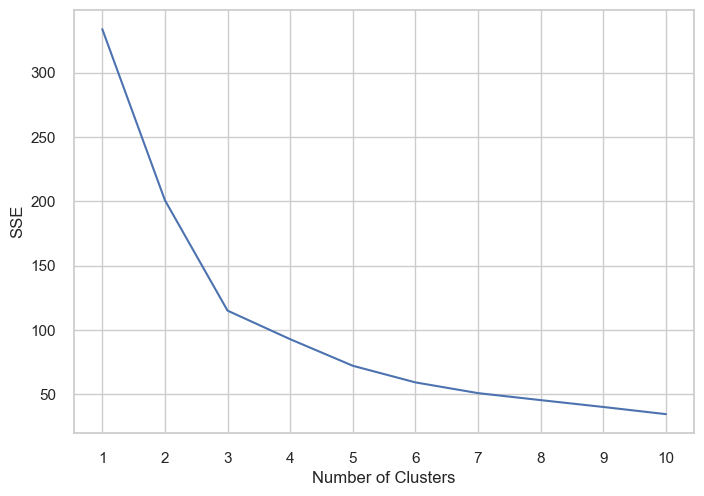

In [8]:
NUMBER_CLUSTER, sse = find_optimal_number_of_cluster(group, k_max)
plt.plot(range(1, k_max), sse)
plt.xticks(range(1, k_max))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

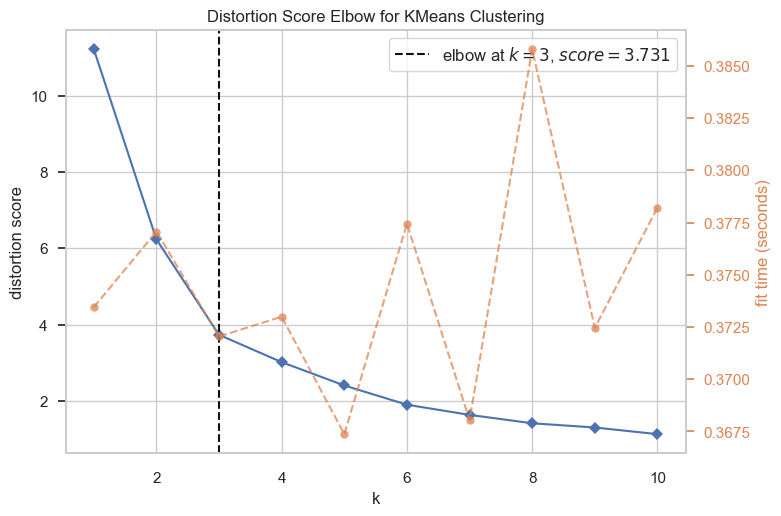

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
model = KMeans()
visualize = KElbowVisualizer(model, k=(1,k_max))
visualize.fit(group)
visualize.poof()

### Clustering test

In [10]:
KMeans_method = cluster.KMeans(init="k-means++", n_clusters=NUMBER_CLUSTER, n_init=10, random_state=24, max_iter=300) #K-Mean
labels_k_mean  = KMeans_method.fit(X).labels_
centers_k_mean = KMeans_method.fit(group).cluster_centers_

centers, labels = find_clusters(X, NUMBER_CLUSTER, rseed=0) #AlgoMax method

SpectralClustering_method = cluster.SpectralClustering(n_clusters=NUMBER_CLUSTER, affinity='nearest_neighbors', assign_labels='kmeans') #Spectral
labels_spectral = SpectralClustering_method.fit_predict(X)

dbscan = cluster.DBSCAN(eps=0.25) #DBscan
scaled_features = scaler.fit_transform(group)
dbscan.fit(scaled_features)
labels_dbscan = dbscan.labels_

df_normalized_example['algo_max'] = labels
df_normalized_example['k-mean'] = labels_k_mean
df_normalized_example['spectral'] = labels_spectral
df_normalized_example['dbscan'] = labels_dbscan

In [11]:
labels_K_Mean = np.insert(np.array(df_normalized_example.loc[:,["k-mean", "imports"]].groupby("k-mean").count().values.tolist()).reshape(-1).astype(str), 0, "K-Mean")
labels_AlgoExp_Max = np.insert(np.array(df_normalized_example.loc[:,["algo_max", "imports"]].groupby("algo_max").count().values.tolist()).reshape(-1).astype(str), 0, "AlgoExp_Max")
labels_Spectral = np.insert(np.array(df_normalized_example.loc[:,["spectral", "imports"]].groupby("spectral").count().values.tolist()).reshape(-1).astype(str), 0, "Spectral")
labels_Dbscan = np.insert(np.array(df_normalized_example.loc[:,["dbscan", "imports"]].groupby("dbscan").count().values.tolist()).reshape(-1).astype(str), 0, "Dbscan")

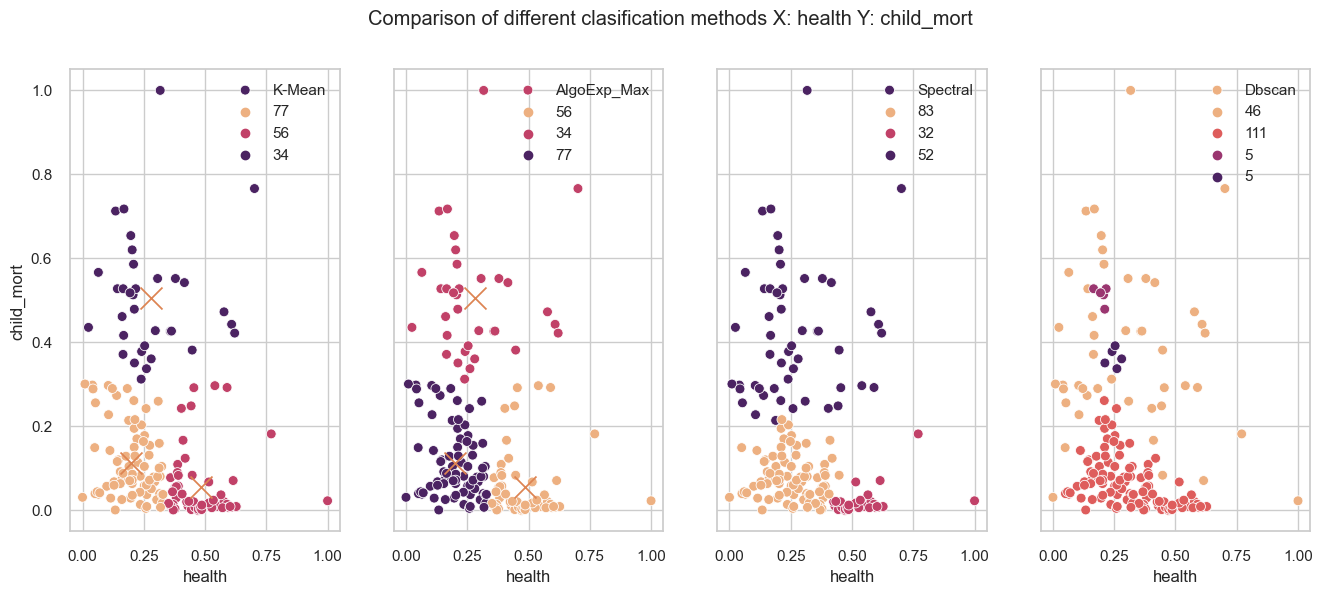

In [12]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 6), sharex=True, sharey=True)


sns.scatterplot(data=df_normalized_example, x=X_label, y=Y_label, hue="k-mean", s=50,alpha=1, palette="flare", ax=ax1)
sns.scatterplot(x=centers_k_mean[:, 0], y=centers_k_mean[:, 1], s=250, zorder=2, marker="x", ax=ax1, legend=None)
ax1.legend(labels=labels_K_Mean)

sns.scatterplot(data=df_normalized_example, x=X_label, y=Y_label, hue="algo_max", s=50,alpha=1, palette="flare", ax=ax2)
sns.scatterplot(x=centers[:, 0], y=centers[:, 1], s=250, zorder=2, marker="x", ax=ax2, legend=None)
ax2.legend(labels=labels_AlgoExp_Max)

sns.scatterplot(data=df_normalized_example, x=X_label, y=Y_label, hue="spectral", s=50,alpha=1, palette="flare", ax=ax3)
ax3.legend(labels=labels_Spectral)

sns.scatterplot(data=df_normalized_example, x=X_label, y=Y_label, hue="dbscan", s=50,alpha=1, palette="flare", ax=ax4)
ax4.legend(labels=labels_Dbscan)

fig.suptitle("Сomparison of different clasification methods X: {} Y: {}".format(X_label, Y_label))
plt.savefig('img/{} clasification methods.jpg'.format(Y_label))

### Conclusion 

The best method for this data frame is the K-Mean, Exp Max.<br> method
The worst method for this dataset is Dbscan, based on the density of points, it determines them into one cluster, other values ​​are no longer clustered and separates them from the noise.

## LET'S GET TO WORK 

### Correlation

Text(0.0, 1.0, 'Feature correlations')

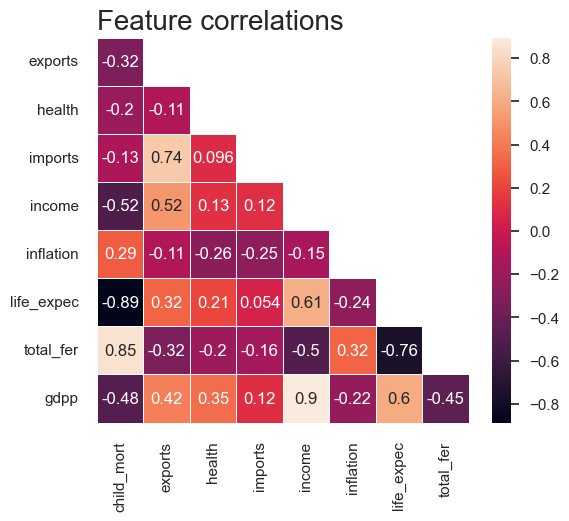

In [13]:
raw_data = pd.read_csv('dataset/Country-data.csv')
df = raw_data.copy()

cors = np.ones_like(df.corr(), dtype=bool)
mask = np.triu(cors)
mask = mask[1:, :-1]

plt.figure(figsize=(6,5))
plt.rcParams["figure.autolayout"] = True

df_corr = df.corr().iloc[1:,:-1]
sns.heatmap(df_corr, annot=True, linewidth=0.4, mask=mask)
plt.yticks(plt.yticks()[0], labels=df_corr.index,rotation=0)
plt.title("Feature correlations", loc="left", fontsize = 20)

We can see the following from the correlation heatmap:

* As expected GDPP and income are highly correlated.
* Number of children born per woman is highly correlated with child mortality, which makes sense.
* Imports and exports are highly correlated as expected.
* Life expectancy is highly negatively correlated with child mortality.
* Life expectancy is correlated with income
* Life expectancy is correlated with GDPP

We can safely drop life expectancy, total fertility and income as they are all very highly correlated to other features

In [14]:
df_clear = df.drop(columns = ['income','country', 'life_expec', 'total_fer']).copy()

### Data Analysis

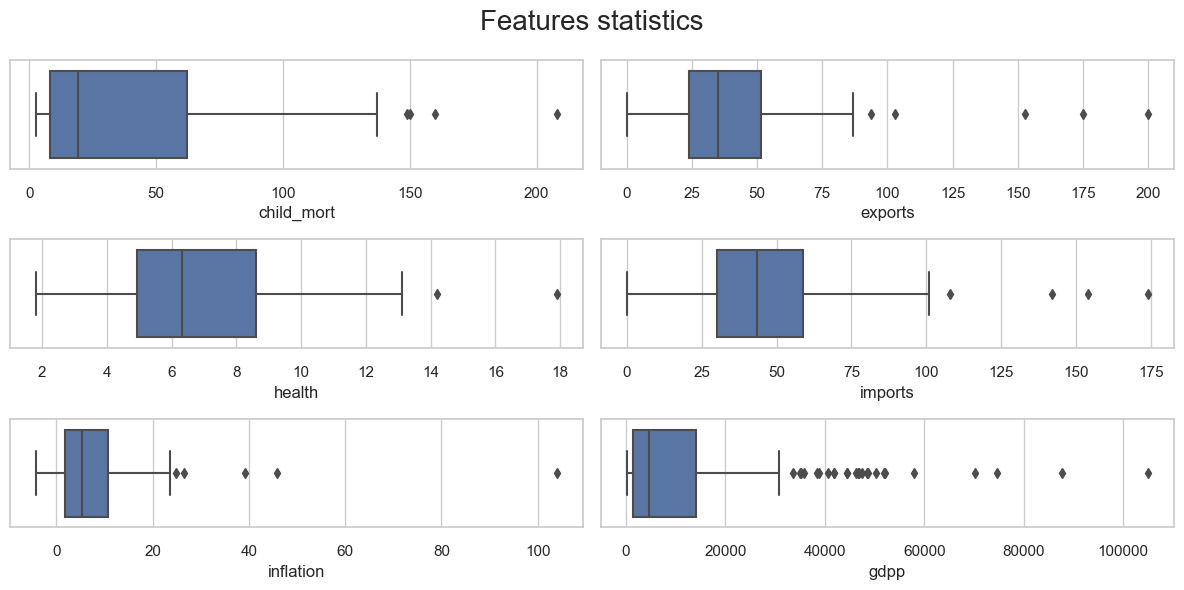

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,6))
plt.suptitle("Features statistics", fontsize=20)
ax = ax.flatten()
for index, column in enumerate(df_clear.columns):
    sns.boxplot(x=df_clear[column], ax=ax[index])

GDPP, inflation, income, imports and exports have many outliers. We cannot change these as these are actually values for the country and dropping them or changing them would change the message from the data.

### Normilaze

In [16]:
df_normalized = normalize(df_clear)

### VISUAL

2    77
0    56
1    34
Name: health_child_mort, dtype: int64

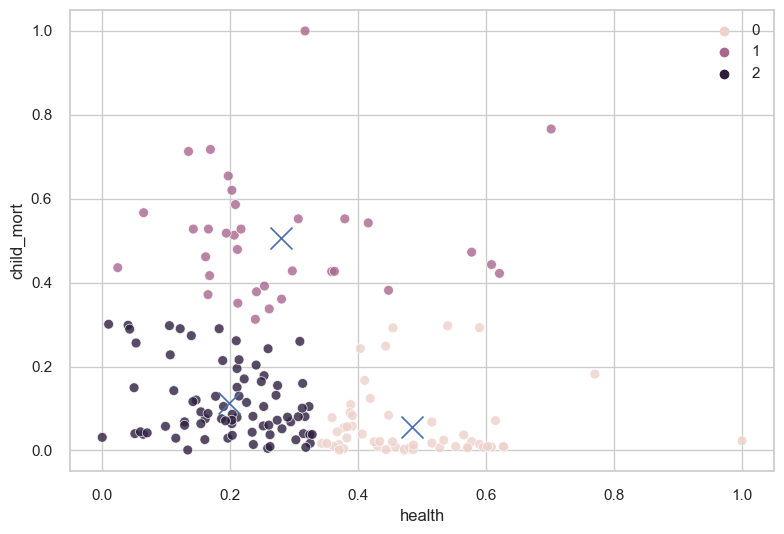

In [17]:
results = pd.DataFrame()
results = clustering(df_normalized, results, 'health', 'child_mort')
results.health_child_mort.value_counts()

1    86
0    51
3    25
2     5
Name: gdpp_imports, dtype: int64

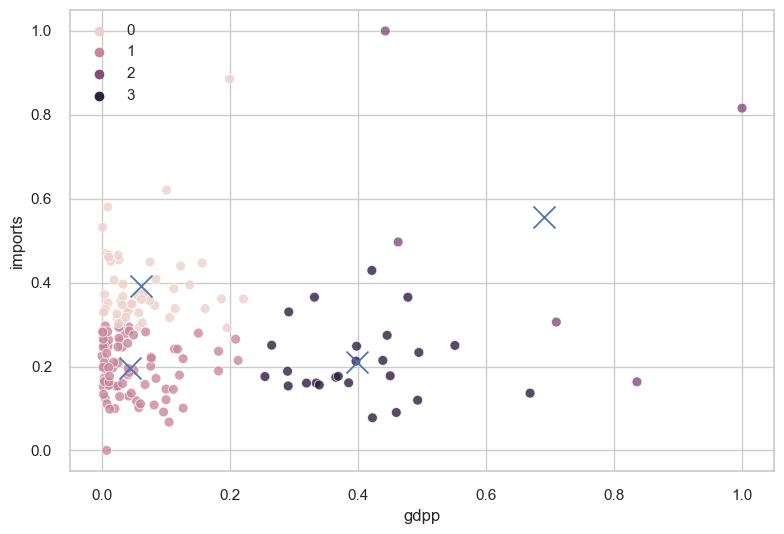

In [18]:
results = clustering(df_normalized, results, 'gdpp', 'imports')
results.gdpp_imports.value_counts()

1    98
0    47
2    22
Name: gdpp_health, dtype: int64

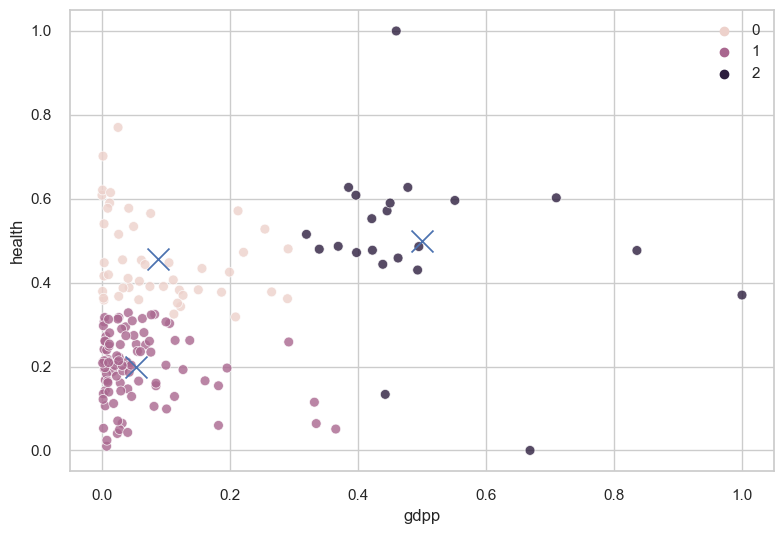

In [ ]:
results = clustering(df_normalized, results, 'gdpp', 'health')
results.gdpp_health.value_counts()

### Quick Solution 

In [21]:
model = KMeans(n_clusters=4, random_state=123)
model.fit(df_normalized)

df['result_cl'] = model.labels_
df.result_cl.value_counts()

3    63
2    41
0    34
1    29
Name: result_cl, dtype: int64

In [22]:
clusters = df.groupby(['result_cl']).mean()
clusters

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
result_cl,,,,,,,,,
0,32.502941,52.779412,5.550294,63.305882,11813.529412,6.650912,69.776471,2.643235,6095.176471
1,5.310345,49.696552,9.082069,42.458621,47786.206897,2.850931,80.241379,1.833103,47068.965517
2,39.151220,37.017561,9.269756,52.614634,11204.219512,6.803000,69.187805,3.021463,7136.756098
3,55.980952,33.520302,4.858254,36.345490,9783.015873,11.298968,67.407937,3.577778,4764.619048


In [24]:
df[df.result_cl==3].head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,result_cl
1,Albania,16.6,28.0,6.55,48.6,9930,4.490,76.3,1.65,4090,3
2,Algeria,27.3,38.4,4.17,31.4,12900,16.100,76.5,2.89,4460,3
3,Angola,119.0,62.3,2.85,42.9,5900,22.400,60.1,6.16,3530,3
6,Armenia,18.1,20.8,4.40,45.3,6700,7.770,73.3,1.69,3220,3
9,Azerbaijan,39.2,54.3,5.88,20.7,16000,13.800,69.1,1.92,5840,3
12,Bangladesh,49.4,16.0,3.52,21.8,2440,7.140,70.4,2.33,758,3
17,Benin,111.0,23.8,4.10,37.2,1820,0.885,61.8,5.36,758,3
19,Bolivia,46.6,41.2,4.84,34.3,5410,8.780,71.6,3.20,1980,3
25,Burkina Faso,116.0,19.2,6.74,29.6,1430,6.810,57.9,5.87,575,3
28,Cameroon,108.0,22.2,5.13,27.0,2660,1.910,57.3,5.11,1310,3


In [26]:
df_result = df[["country"]][df.result_cl==3]
df_result.to_csv('result_cluster.csv', encoding='utf-8', index=False)

## OLD developments

In [36]:
def result_def(df, target, limit=0):
    df_result = pd.DataFrame(df.country, columns=["country"])
    clear = df.drop(columns=['country'])
    df = normalize(clear)
    if limit==0: limit=len(df.columns)-1
    df_result[target]=round(df[target], 5)
    fig, axes = plt.subplots(1, limit, figsize=(3*limit, 6))
    for index, y_label in enumerate(df.columns[:limit+1]):
        print("iteration: {} x: {} target: {}".format(index+1, y_label, target))
        if target != y_label and df[y_label].dtypes != object:
            group = df[[y_label,target]]
            X = np.array(group.values.tolist())
            
            NUM_CLUSTER, see = find_optimal_number_of_cluster(X, 11)
            print("Count clusters: {}".format(NUM_CLUSTER))
            
            centers, labels = find_clusters(X, NUM_CLUSTER, rseed=0)
            key='cl_'+y_label
            df_result[key] = labels
            df[key] = labels
            
            axes[index].get_xaxis().set_visible(False)
            sns.scatterplot(data=df, x=target, y=y_label, hue=key, s=50,alpha=0.45, palette="flare", ax=axes[index])
            sns.scatterplot(x=centers[:, 1], y=centers[:, 0], s=250, zorder=2, marker="x", ax=axes[index], palette=["black"]);
            sns.move_legend(axes[index], "upper center", ncol=2, frameon=False, bbox_to_anchor=(.5, 0), title=y_label)
            axes[index].set(ylabel=None)
            axes[index].label_outer()
    fig.suptitle("Сomparison of different features using Exp max method with X label: {}".format(target))
    plt.savefig('img/{} clasification features.jpg'.format(target))
    return df_result

iteration: 1 x: child_mort target: gdpp
Count clusters: 3
iteration: 2 x: exports target: gdpp
Count clusters: 4
iteration: 3 x: health target: gdpp
Count clusters: 3
iteration: 4 x: imports target: gdpp
Count clusters: 4
iteration: 5 x: income target: gdpp
Count clusters: 3
iteration: 6 x: inflation target: gdpp
Count clusters: 4
iteration: 7 x: life_expec target: gdpp
Count clusters: 3
iteration: 8 x: total_fer target: gdpp
Count clusters: 3
iteration: 9 x: gdpp target: gdpp


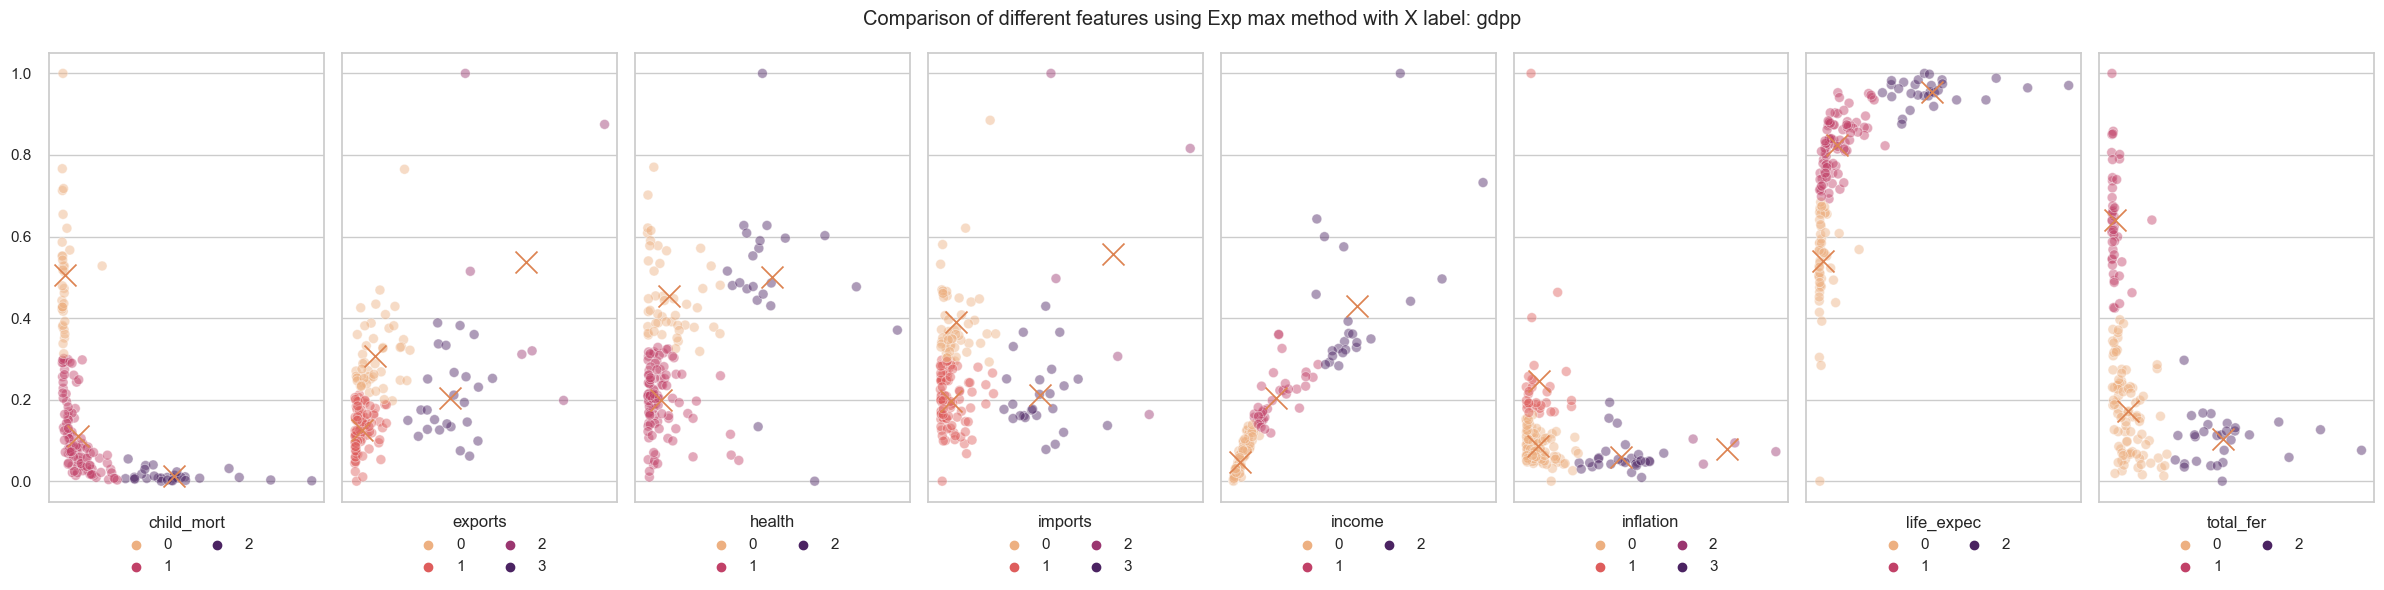

In [37]:
df = pd.read_csv('dataset/Country-data.csv')
result_df_old = result_def(df.copy(), "gdpp")

In [38]:
result_df_old.insert(2, 'result_cl', model.labels_)

In [39]:
result_df_old.head()

,country,gdpp,result_cl,cl_child_mort,cl_exports,cl_health,cl_imports,cl_income,cl_inflation,cl_life_expec,cl_total_fer
0,Afghanistan,0.00307,2,0,1,0,1,0,0,0,1
1,Albania,0.03683,3,1,1,1,1,0,0,1,0
2,Algeria,0.04036,3,1,1,1,1,0,1,1,0
3,Angola,0.03149,3,0,0,1,1,0,1,0,1
4,Antigua and Barbuda,0.11424,0,1,0,1,0,1,0,1,0


In [40]:
df_result = result_df_old[(result_df_old.cl_child_mort == 0)
               &(result_df_old.cl_health==1)
               &(result_df_old.cl_inflation==1)].sort_values("gdpp").reset_index(drop=True)

In [41]:
df_result

,country,gdpp,result_cl,cl_child_mort,cl_exports,cl_health,cl_imports,cl_income,cl_inflation,cl_life_expec,cl_total_fer
0,Guinea,0.00398,3,0,1,1,1,0,1,0,1
1,Mauritania,0.00925,0,0,0,1,0,0,1,1,1
2,Ghana,0.01030,3,0,1,1,1,0,1,0,1
3,Zambia,0.01173,3,0,1,1,1,0,1,0,1
4,Sudan,0.01192,3,0,1,1,1,0,1,0,1
5,Nigeria,0.02003,3,0,1,1,1,0,1,0,1
6,Angola,0.03149,3,0,0,1,1,0,1,0,1
7,Equatorial Guinea,0.16101,0,0,0,1,0,1,1,0,1


In [42]:
df_result_using_cluster = result_df_old[(result_df_old.result_cl==3)].sort_values("gdpp").reset_index(drop=True)
df_result_using_cluster.to_csv('result_cluster_var2.csv', encoding='utf-8', index=False)

In [43]:
df_result_using_cluster

,country,gdpp,result_cl,cl_child_mort,cl_exports,cl_health,cl_imports,cl_income,cl_inflation,cl_life_expec,cl_total_fer
0,Niger,0.00112,3,0,1,1,1,0,0,0,1
1,Madagascar,0.00174,3,1,1,1,1,0,0,0,1
2,Mozambique,0.00179,3,0,1,1,1,0,0,0,1
3,Central African Republic,0.00205,3,0,1,1,1,0,0,0,1
4,Malawi,0.00218,3,0,1,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
58,Venezuela,0.12665,3,1,1,1,1,1,1,1,0
59,Saudi Arabia,0.18201,3,1,0,1,1,1,1,1,0
60,Oman,0.18201,3,1,0,1,1,1,1,1,0
61,South Korea,0.20874,3,1,0,0,1,1,0,1,0
